# Training Deep Neural Networks

Training a deep DNN isn’t a walk in the park. Here are 
some of the problems you could run into:

You may be faced with the tricky vanishing gradients problem or the related exploding gradients problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train

You might not have enough training data for such a large network, or it might be too costly to label.

Training may be extremely slow

A model with millions of parameters would severely risk overfitting the training 
set, especially if there are not enough training instances or if they are too noisy

In [78]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

## The Vanishing/Exploding Gradients Problems

As we discussed in Chapter 10, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient along the way. Once the algorithm has computed the gradient of the cost function with regard to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step.

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the vanishing gradients problem. In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio.

### IMPORTANT POINT!!!!!!!!!!!!!!!!!!!!!!
The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

#### Plotting the Logistic Sigmoid Activation Function
Looking at the logistic activation function (see below), you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

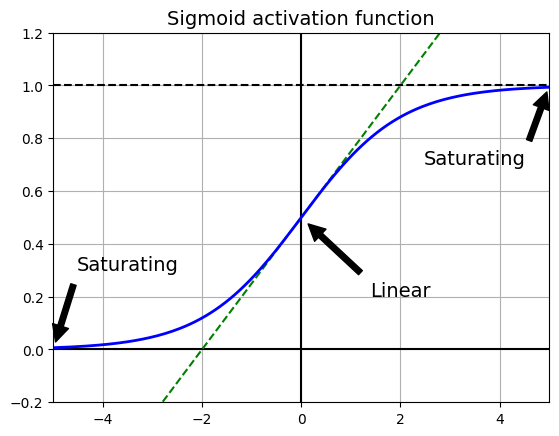

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Glorot and He Initialization

In their paper, Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate.

For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs(Here’s an analogy: if you set a microphone amplifier’s knob too close to zero, people won’t hear your voice, but if you set it too close to the max, your voice will be saturated and people won’t understand what you are saying. Now imagine a chain of such amplifiers: they all need to be set properly in order for your voice to come out loud and clear at the end of the chain. Your voice has to come out of each amplifier at the same amplitude as it came in.)

Also, we need the gradients to have equal variance before and after flowing through a layer in the reverse direction

It is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer)

#### Initialization Equation

But Glorot and Bengio proposed a good compro mise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly as described in equation below.

#### Equation :- Glorot initialization (when using the logistic activation function)

fanavg = (fanin + fanout)/2

Normal distribution with mean 0 and variance σ2 = 1 / fan avg 

Or a uniform distribution between −r and + r, with r = sqrt (3 /fan avg)

If you replace fanavg with fanin in the above Equation, you get an initialization strategy that Yann LeCun proposed in the 1990s. He called it LeCun initialization. Genevieve Orr and Klaus-Robert Müller even recommended it in their 1998 book Neural Networks: Tricks of the Trade (Springer). LeCun initialization is equivalent to Glorot initialization when fanin = fanout . It took over a decade for researchers to realize how important this trick is. Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning.

#### See table 11.1 in the textbook for different initialization strategy and the activation function

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting kernel_initializer="he_uniform" or kernel_initializer="he_normal" like this:

 keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

If you want He initialization with a uniform distribution but based on fanavg rather than fanin , you can use the VarianceScaling initializer like this:

he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',  distribution='uniform')

 keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### ReLU

### ReLU activation function behaves much better in deep neural networks in particular, mostly because it does not saturate for positive values (and because it is fast to compute)

### PROBLEM OF RELU!!!!!

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs: during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative


#### NOTE
Unless it is part of the first hidden layer, a dead neuron may sometimes come back to life: Gradient Descent may indeed tweak neurons in the layers below in such a way that the weighted sum of the dead neuron’s inputs is positive again.

#### Plotting ReLU

In [4]:
def relu(z):
    return np.maximum(0, z)

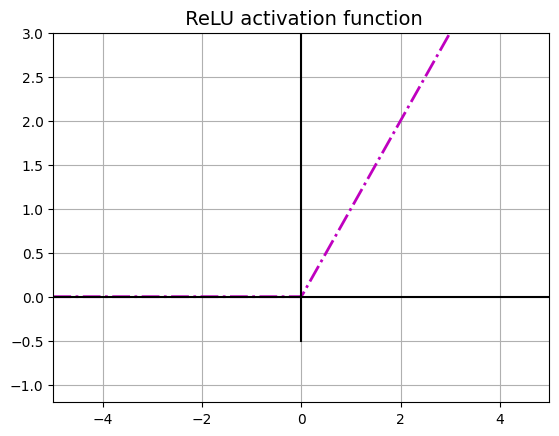

In [5]:
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
plt.title(" ReLU activation function", fontsize=14)
plt.axis([-5, 5, -1.2, 3])
plt.show()

### LeakyReLU

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU. This function is defined as LeakyReLUα(z) = max(αz, z). The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0 and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

#### Plotting Leaky ReLU

In [6]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

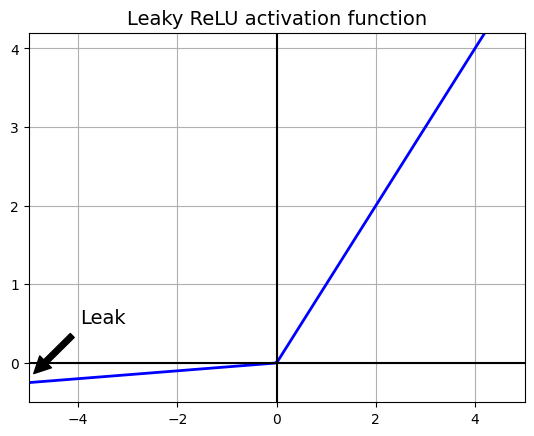

In [7]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

### Versions of ReLU

The paper Bing Xu et al., “Empirical Evaluation of Rectified Activations in Convolutional Network” compared several variants of the ReLU activation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting α = 0.2 (a huge leak) seemed to result in better performance than α = 0.01 (a small leak). The paper also evaluated the randomized leaky ReLU (RReLU), where α is picked randomly in a given range during training and is fixed to an average value during testing. RReLU also performed fairly well and seemed to act as a regularizer (reducing the risk of overfitting the training set). Finally, the paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

## ELU (Exponential Linear Unit)

The 2015 paper by Djork-Arné Clevert et al proposed a new activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set.

0

### ELU equation

ELUαz = α (exp (z) − 1) if z < 0 or z if z ≥ 0

In [8]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

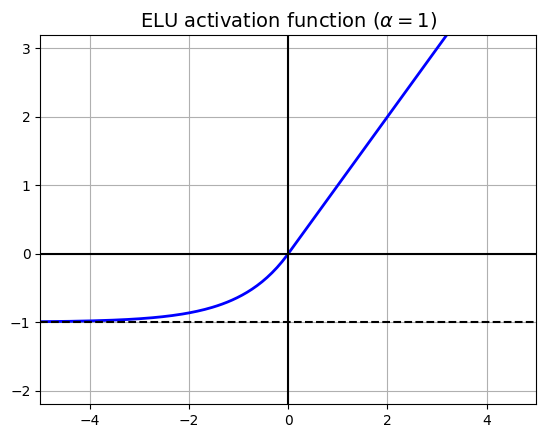

In [9]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

### Charactersitics of ELU

The ELU activation function looks a lot like the ReLU function, with a few major differences:
1. It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter α defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter.
2. It has a nonzero gradient for z < 0, which avoids the dead neurons problem.
3. If α is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0.

### Drawbacks of ELU

The main drawback of the ELU activation function is that it is slower to compute than the ReLU function and its variants (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

## SELU Scaled ELU

As the name suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize: the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones).

#### Pre-conditions for SELU

For the SELU to work as awesome, There are, however, a few conditions for self-normalization to happen :
1. The input features must be standardized (mean 0 and standard deviation 1).
2. Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting kernel_initializer="lecun_normal".
3. The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.

# WHICH ACTIVATION FUNCTION TO USE???

So, which activation function should you use for the hidden layers of your deep neural networks? Although your mileage will vary, in general follow the below

SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic

If the network’s architecture prevents it from selfnormalizing, then ELU may perform better than SELU (since SELUis not smooth at z = 0). If you care a lot about runtime latency, then you may prefer leaky ReLU.

If you don’t want to tweak yet another hyperparameter, you may use the default α values used by Keras (e.g., 0.3 for leaky ReLU).

If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set.

That said, because ReLU is the most used activation function (by far), many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.

### Using the Activation functions

#### Leaky ReLU

To use the leaky ReLU activation function, create a LeakyReLU layer and add it to your model just after the layer you want to apply it to:
model = keras.models.Sequential([
 [...]
 keras.layers.Dense(10, kernel_initializer="he_normal"),
 keras.layers.LeakyReLU(alpha=0.2),
 [...]
])

#### SELU
For SELU activation, set activation="selu" and kernel_initializer="lecun_normal" when creating a layer:
layer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

# BATCH NORMALIZATION

In a 2015 paper,Sergey Ioffe and Christian Szegedy proposed a technique called Batch Normalization (BN) that addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. 

This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. The part "In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs" means that the model is also learning what is the scale and mean of the inputs that are being passed to the layers

In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

#### How to batch normalize, i.e. zero center and normalize

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and standard deviation of the input over the current mini-batch (hence the name “Batch Normalization”).

### IMPORTANT!!!! Refer the Batch Normalization Algorithm from the textbook, pg 339

### Batch Normalization during Training and Testing

#### Problem

So during training, BN standardizes its inputs, then rescales and offsets them. Good! What about at test time? Well, it’s not that simple. Indeed, we may need to make predictions for individual instances rather than for batches of instances: in this case, we will have no way to compute each input’s mean and standard deviation.

Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable.

#### Solution

One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These “final” input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions.

#### Solution Discussion

However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer’s input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer. To sum up, four parameter vectors are learned in each batch-normalized layer: γ (the output scale vector) and β (the output offset vector) are learned through regular backpropagation, and μ (the final input mean vector) and σ (the final input standard deviation vector) are estimated using an exponential moving average. Note that μ and σ are estimated during training, but they are used only after training (to replace the batch input means and standard deviations in the batch normalization algorithm equation on pg 339)

#### Batch Normalization as Regularization
Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout)

## Complexity due to Batch Normalization

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer

### Solving the complexity


Fortunately, it’s often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty. This is done by updating the previous layer’s weights and biases so that it directly produces outputs of the appropriate scale and offset.et.

For example, if the previous layer computes XW + b, then the BN layer will compute γ⊗(XW + b – μ)/σ + β (ignoring the smoothing term ε in the denominator). If we define W′ = γ⊗W/σ and b′ = γ⊗(b – μ)/σ + β, the equation simplifies to XW′ + b′. So if we replace the previous layer’s weights and biases (W and b) with the updated weights and biases (W′ and b′), we can get rid of the BN layer (TFLite’s optimizer does this automatically)

#### General Note Batch Normalization
You may find that training is rather slow, because each epoch takes much more time when you use Batch Normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, wall time will usually be shorter (this is the time measured by the clock on your wall).

### Implementing Batch Normalization with Keras

In [10]:
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(10, activation="softmax")
])


#### Model Summary

In [11]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

#### Model Explanation IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

As you can see, each BN layer adds four parameters per input: γ, β, μ, and σ (for example, the first BN layer adds 3,136 parameters, which is 4 × 784). The last two parameters, μ and σ, are the moving averages; they are not affected by backpropagation, so Keras calls them “non-trainable” (if you count the total number of BN parameters, 3,136 + 1,200 + 400, and divide by 2, you get 2,368, which is the total number of non-trainable parameters in this model).

### Note about Non-trainable

In the above example, although, μ and σ are marked as non-trainable by keras, However, they are estimated during training, based on the training data, so arguably they are trainable. In Keras, “non-trainable” really means “untouched by backpropagation.”

#### Analysing BN layers

Let's look at the first BN layer

In [12]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

True means trainable by backpropogation, False means non-trainable. Hence, two are trainable and two are not

#### Note about TF Backend

Now when you create a BN layer in Keras, it also creates two operations that will be called by Keras at each iteration during training. These operations will update the moving averages. Since we are using the TensorFlow backend, these operations are TensorFlow operations

## Where to add Batch Normalization

The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did).

There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset.

#### Adding Batch Normalization before Activation Function

To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it):

In [13]:
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.BatchNormalization(),
 keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
 keras.layers.BatchNormalization(),
 keras.layers.Activation("elu"),
 keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
 keras.layers.BatchNormalization(),
 keras.layers.Activation("elu"),
 keras.layers.Dense(10, activation="softmax")
])

## Batch Normalization Parent Class

The BatchNormalization class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the momentum. This hyperparameter is used by the BatchNormalization layer when it updates the exponential moving averages; given a new value v (i.e., a new vector of input means or standard deviations computed over the current batch), the layer updates the running average v^ using the following equation:

#### Equation for updating the running average using the momentum
v^ <- v^ × momentum + v × (1 − momentum)

##### Good momentum value
A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datasets and smaller mini-batches).

### Batch Normalization Hyperparameter Axis

Another important hyperparameter is axis: it determines which axis should be normalized. It defaults to –1, meaning that by default it will normalize the last axis (using the means and standard deviations computed across the other axes). When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch.

### Important
Now note that batch size by default is 32, or can be defined separately in fit(), here the part "input batch is 2D (i.e., the batch shape is [batch size, features])" means the None, 784 part that is present in the first layer for model.summary in Implementing Batch Normalization with Keras

### 2D Batch Size for Batch Normalization
When the input batch is 2D (i.e., the batch shape is [batch size, features]), like the None, 784 just mentioned before, this means that each input feature will be normalized based on the mean and standard deviation computed across all the instances in the batch. For example, the first BN layer in the previous code example will independently normalize (and rescale and shift) each of the 784 input features.

### 3D Batch Size for Batch Normalization
If we move the first BN layer before the Flatten layer, then the input batches will be 3D, with shape [batch size, height, width]; therefore, the BN layer will compute 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 scale parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set axis=[1, 2].

### Explanation for 3D
Explaining this part, now you are not flattening the input before passing it to Batch Normalization, hence what BN gets is [32,28,28] which basically is the default batch size with 28x28 2D image pixels for each image. Hence since by default BN uses -1 i.e. the last axis, which basically means the last value that is there in the [32,28,28], it will just calculate 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. This is acually reducing the mean and the standard deviation from the before 784 count. 

#### Explanation for axis = [1,2]
Now, in the above example, how does axis = [1,2] instructs BN to reat each of the 784 pixels independently? so when you pass [1,2], it tells BN that from the 3D input batches that you get which are [32,28,28], select the values that are at 1st and 2nd index, which 28,28 in our case. Then as you already know that All axes not listed in axis are the ones over which BN will compute the mean/variance. The axes in axis are the ones that define which features get distinct normalization. Hence, BatchNormalization(axis=[1, 2]), BN computes:mean = input.mean(axis=0) 
std  = input.std(axis=0 which means 32 in our case, hence it will take 28,28 together, and compute mean and standard deviation over each batch of 32 inputs, like it did when we put a flatten layer before the BN layer) 

### Batch Normalization Conclusion


BatchNormalization has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer. But a recent paper11 by Hongyi Zhang et al. may change this assumption: by using a novel fixed-update (fixup) weight initialization technique, the authors managed to train a very deep neural network (10,000 layers!) without BN, achieving state-of-the-art performance on complex image classification tasks. As this is bleeding-edge research, however, you may want to wait for additional research to confirm this finding before you drop Batch Normalization.

## Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. This is called Gradient Clipping. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs. For other types of networks, BN is usually sufficient.

In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer, like this:

In [14]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

This optimizer will clip every component of the gradient vector to a value between –1.0 and 1.0. This means that all the partial derivatives of the loss (with regard to each and every trainable parameter) will be clipped between –1.0 and 1.0. The threshold is a hyperparameter you can tune.

### Changing the direction of Gradient due to Gradient Clipping


Note that it may change the orientation of the gradient vector. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well.

### Avoiding changing the direction of the gradient vector

If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its ℓ2 norm is greater than the threshold you picked.

For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component.

#### Note gradient clipping
If you observe that the gradients explode during training (you can track the size of the gradients using TensorBoard), you may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle then reuse the lower layers of this network. This technique is called transfer learning. It will not only speed up training considerably, but also require significantly less training data.

#### Example scenario for using pretrained layers

Suppose you have access to a DNN that was trained to classify pictures into 100 different categories, including animals, plants, vehicles, and everyday objects. You now want to train a DNN to classify specific types of vehicles. These tasks are very similar, even partly overlapping, so you should try to reuse parts of the first network

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

## Transfer Learning

### Important warning about Transfer Learning
If the input pictures of your new task don’t have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generally, transfer learning will work best when the inputs have similar low-level features.
es.

### Pro-Tip Transfer Learning
The more similar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replacing the output layer.

### Transfer Learning Process

Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won’t modify them), then train your model and see how it performs.

Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves.

The more training data you have, the more layers you can unfreeze. 

#### Important Note about the Learning rate when using pretrained layers and unfreezing them!!!

It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.

### Transfer Learning how to improve performance
If you still cannot get good performance, and you have little training data, try drop‐
ping the top hidden layer(s) and freezing all the remaining hidden layers again. You
can iterate until you find the right number of layers to reuse. If you have plenty of
training data, you may try replacing the top hidden layers instead of dropping them,
and even adding more hidden layers.

## Transfer Learning with KERAS

Let’s look at an example. Suppose the Fashion MNIST dataset only contained eight classes—for example, all the classes except for sandal and shirt. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirt, negative=sandal). Your dataset is quite small; you only have 200 labeled images. When you train a new model for this task (let’s call it model B) with the same architecture as model A, it performs reasonably well (97.2% accuracy). But since it’s a much easier task (there are just two classes), you were hoping for more. While drinking your morning coffee, you realize that your task is quite similar to task A, so perhaps transfer learning can help? Let’s find out!

#### Loading model A


In [15]:
model_A = keras.models.load_model("my_keras_best_model.keras")

In [16]:
model_A.layers

In [17]:
model_A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 30)                270       
                                                                 
 dense_16 (Dense)            (None, 1)                 31        
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Creating model B

In [18]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

#### WARNING ABOUT TRAINING IN TRANSFER LEARNING!!
model_A and model_B_on_A now share some layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you clone model A’s architecture with clone_model(), then copy its weights (since clone_model() does not clone the weights):


#### Cloning model A to preserve it's weights


In [19]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

### Training model B

Now you could train model_B_on_A for task B, but since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s trainable attribute to False and compile the model:

In [20]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [21]:
model_B_on_A.compile(loss="binary_crossentropy", optimizer="sgd",
 metrics = ['accuracy'])

#### Compiling model WARNING!!!!!!!!!!!!!! You must always compile your model after you freeze or unfreeze layers.


Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
 validation_data=(X_valid_B, y_valid_B))

In [22]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=1e-4) # the default lr is 1e-2
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
 metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
 validation_data=(X_valid_B, y_valid_B))

## Unsupervised Pretraining

#### Scenario

Suppose you want to tackle a complex task for which you don’t have much labeled training data, but unfortunately you cannot find a model trained on a similar task. Don’t lose hope! First, you should try to gather more labeled training data, but if you can’t, you may still be able to perform unsupervised pretraining

#### Solution to the Scenario

Indeed, it is often cheap to gather unlabeled training examples, but expensive to label them. If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network

Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN’s discriminator, add the output layer for your task on top, and finetune the final network using supervised learning (i.e., with the labeled training examples).

## Pretraining on an Auxiliary Task

If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network’s lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual—clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person.

Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

#### NLP in Auxiliary learning

For natural language processing (NLP) applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence “What ___ you saying?” is probably “are” or “were”). If you can train a model to reach good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data 

### Self-Supervised Learning
Self-supervised learning is when you automatically generate the labels from the data itself, then you train a model on the resulting “labeled” dataset using supervised learning techniques. Since this approach requires no human labeling whatsoever, it is best classified as a form of unsupervised learning.

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using Batch Normalization, and reusing parts of a pretrained network (possibly built on an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer. In this section we will present the most popular algorithms: momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam and Nadam optimization.

## Momentum Optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind momentum optimization

##### How is regular gradient descent different from Momentum Optimization

a regular Gradient Descent simply takes small, regular steps down the slope, so the algorithm will take much more time to reach the bottom.


##### How Gradient Descent updates the weights

Recall that Gradient Descent updates the weights θ by directly subtracting the current weights with gradient of the cost function J(θ) with regard to the current weights i.e. (∇θ J(θ)) multiplied by the learning rate η. The equation is: 

θ ← θ – η∇θJ(θ) 

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly

#### How Momentum Optimization works

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the momentum vector m, and it updates the weights by adding this momentum vector (see Equation below).

Step1 :- m <- βm − η∇θJ(θ)

Step2 :- 
θ <- θ + 

To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter β, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.m

#### Momentum Optimization working example(couldn't understand this)
You can easily verify that if the gradient remains constant, the terminal velocity (i.e., the maximum size of the weight updates) is equal to that gradient multiplied by the learning rate η multiplied by 1/(1–β) (ignoring the sign). For example, if β = 0.9, then the terminal velocity is equal to 10 times the gradient times the learning rate, so momentum optimization ends up going 10 times faster than Gradient Descent! This allows momentum optimization to escape from plateaus much faster than Gradient Descent. 


#### Momentum Optimization working Keras

In [24]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

One small variant to momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla momentum optimization. The Nesterov Accelerated Gradient (NAG) method, also known as Nesterov momentum optimization, measures the gradient of the cost function not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm (see Equation below).

Equation Nesterov Accelerated Gradient algorithm


Step1 : m <- βm − η∇θ J(θ + βm)


Step2 : θ <- θ + m

#### How Nesterov Accelerated Gradient works?

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position, as you can see in Figure 11-6 ...refer textbook (where ∇1 represents the gradient of the cost function measured at the starting point θ, and ∇2 represents the gradient at the point located at θ + βm).

#### Nestorov Accelerated Gradient conclusion
As you can see, the Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular momentum optimization. Moreover, note that when the momentum pushes the weights across a valley, ∇1 continues to push farther across the valley, while ∇2 pushes back toward the bottom of the valley. This helps reduce oscillations and thus NAG converges faster.

##### Nestorov Accelerated Gradient with Keras

In [25]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

##### Warning
AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though Keras has an Adagrad optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though). Still, understanding AdaGrad is helpful to grasp the other adaptive learning rate optimizers.izers.

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum.

### AdaGrad equation
Step1 : s <- s + ∇θ.J(θ) ⊗ ∇θ.J(θ)


Step2 : θ <- θ − η ∇θ.J(θ) ⊘ sqrt(s + ε)

### Explanation Adagrad equation

#### First step

The first step accumulates the square of the gradients into the vector s (recall that the  
⊗ symbol represents the element-wise multiplication). This vectorized form is equivalent to computing si ← si + (∂ J(θ) / ∂ θi)^2for each element si of the vector s; in other words, each si accumulates the squares of the partial derivative of the cost function with regard to parameter θi. If the cost function is steep along the ith dimension, then si will get larger and larger at each iteration.

#### Second Step

The second step is almost identical to Gradient Descent,(the ⊘ symbol represents the element-wise division, and ε is a smoothing term to avoid division by zero, typically set to 10^ -10). The one big difference from Gradient descent is that the gradient vector is scaled down by a factor of  sqrt(s + ε)

#### Adagrad in keras

In [26]:

optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### Adagrad Conclusive statement

In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum. One additional benefit is that it requires much less tuning of the learning rate hyperparameter η.

## RMSProp

As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. 

### Working RMSProp algorithm

The RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations as opposed to all the gradients since the beginning of training. It does so by using exponential decay in the first step

#### RMSProp Equation

Equation RMSProp algorithm


Step 1 s <- βs + (1 − β).∇θ.J(θ) ⊗ ∇θ.J(θ)




Step 2 θ <- θ − η.∇θ.(Jθ) ⊘ sqrt(s + ε)

#### Parameter RMSProp
The decay rate β is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value often works well, so you may not need to tune it at all.

#### Implementing RMSProp in Keras

In [27]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9) #Note that the rho argument corresponds to β


## Adam and Nadam Optimization  IMPORTANT!!!

Adam,  which stands for adaptive moment estimation, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients 

#### Equation of Adam Optimizer

Equation 11-8. Adam algorithm
1) m <- β1m − (1 − β1).∇θ.J(θ)


2) s <- β2.s + (1 − β2).∇θ.J(θ) ⊗ ∇θ.J(θ)


3) m <- m /(1 − β1^t)


4) s <- s /(1 − β2^t)


5) θ <− θ + η.m ⊘ sqrt(s + ε) 

#### Explanation of equation


In this equation, t represents the iteration number (starting at 1).

##### STEPS 1,2 and 5

If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both momentum optimization and RMSProp. The only difference is that step 1 computes an exponentially decaying average rather than an exponentially decaying sum, but these are actually equivalent except for a constant factor (the decaying average is just 1 – β1 times the decaying sum).

##### STEPS 3 and 4

Steps 3 and 4 are somewhat of a technical detail: since m and s are initialized at 0, they will be biased toward 0 at the beginning of training, so these two steps will help boost m and s at the beginning of training and reduce the bias

##### The hyperparameters
The momentum decay hyperparameter β1 is typically initialized to 0.9, while the scaling decay hyperparameter β2 is often initialized to 0.999. As earlier, the smoothing term ε is usually initialized to a tiny number such as 10^–7. These are the default values for the Adam class (to be precise, epsilon defaults to None, which tells Keras to use keras.backend.epsilon(), which defaults to 10^–7; you can change it using keras.backend.set_epsilon())

#### Implementing Adam in Keras

In [28]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Variants of ADAM optimizer

### AdaMax
Notice that in step 2 of Adam optimizer Equation , Adam accumulates the squares of the gradients in s (with a greater weight for more recent gradients). In step 5, if we ignore ε and steps 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the square root of s. In short, Adam scales down the parameter updates by the ℓ2 norm of the time-decayed gradients (recall that the ℓ2 norm is the square root of the sum of squares, and here the vector s accumulates the square of the gradients). AdaMax, introduced in the same paper as Adam, replaces the ℓ2 norm with the ℓ∞ norm (a fancy way of saying the max). Specifically, it replaces step 2 in the Adam optimizer Equation with s ← max(β2s,∇θJ(θ)), it drops step 4, and in step 5 it scales down the gradient updates by a factor of s, which is just the max of the time-decayed gradients. In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer you can try if you experience problems with Adam on some task.

### Nadam
Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

## Important Note about Adaptive optimizers!!!


Adaptive optimization methods (including RMSProp, Adam, and Nadam optimization) are often great, converging fast to a good solution. However, a 2017 paper20 by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model’s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it’s moving fast.

## Second Order Derivatives

All the optimization techniques discussed so far only rely on the first-order partial derivatives (Jacobians). The optimization literature also contains amazing algorithms based on the second-order partial derivatives (the Hessians, which are the partial derivatives of the Jacobians). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n 2 Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow

### Pro-Tip

Check out the TensorFlow Model Optimization Toolkit (TF-MOT), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

## Learning Rate Scheduling

Finding a good learning rate is very important. If you set it much too high, training may diverge (as we discussed in “Gradient Descent” on page 118). If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.


As we discussed in Chapter 10, you can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. You can then reinitialize your model and train it with that learning rate.


But you can do better than a constant learning rate: if you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These strategies are called learning schedules (we briefly introduced this concept in Chapter 4). These are the most commonly used learning schedules:

### Different Learning Rate Schedules

### Power scheduling

Set the learning rate to a function of the iteration number t, i.e. η(t) = η0 / (1 + t/s)^c.The initial learning rate η0 , the power c (typically set to 1), and the steps s are hyperparameters. The learning rate drops at each step. After s steps, it is down to η0/2. After s more steps, it is down to η0/3, then it goes down to η0/4, then η0/5, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning η0 and s (and possibly c).

### Exponential scheduling

Set the learning rate to η(t) = η0 x 0.1^(t/s). The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

### Piecewise constant scheduling

Use a constant learning rate for a number of epochs (e.g., η0 = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η1 = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

### Performance scheduling


Measure the validation error every N steps (just like for early stopping), and
reduce the learning rate by a factor of λ when the error stops dropping.


### 1 cycle scheduling

Contrary to the other approaches, 1cycle (introduced in a 2018 paper21 by Leslie Smith) starts by increasing the initial learning rate η0, growing linearly up to η1 halfway through training. Then it decreases the learning rate linearly down to η0 again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate η1 is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate η0 is chosen to be roughly 10 times lower. 

#### 1 cycle approach with momentum optimization

When using a momentum, we start with a high momentum first (e.g.,0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance.


### Research results on learning rate schedulers

A 2013 paper22 by Andrew Senior et al. compared the performance of some of the most popular learning schedules when using momentum optimization to train deep neural networks for speech recognition. The authors concluded that, in this setting, both performance scheduling and exponential scheduling performed well. They favored exponential scheduling because it was easy to tune and it converged slightly faster to the optimal solution (they also mentioned that it was easier to implement than performance scheduling, but in Keras both options are easy). That said, the 1cycle approach seems to perform even better

## Implementing Learning rate schedulers in Keras

### Power Scheduling

Implementing power scheduling in Keras is the easiest option: just set the decay hyperparameter when creating an optimizer:

In [29]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

The decay is the inverse of s (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that c is equal to 1.


### Exponential Scheduling

 You first need to define a function that takes the current epoch and returns the learning rate. For example, let’s implement exponential scheduling:


In [30]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

If you do not want to hardcode η0 and s, you can create a function that returns a configured function:

In [31]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

In [32]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

Next, create a LearningRateScheduler callback, giving it the schedule function, and 
pass this callback to the fit() method:

In [33]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler])

#### Exponential Scheduling working
The LearningRateScheduler will update the optimizer’s learning_rate attribute at the beginning of each epoch. Updating the learning rate once per epoch is usually enough, but if you want it to be updated more often, for example at every step(here step is that the gradient descent algorithm takes on the curve to reach the global optimum, or, you can simply define step to be equal to the number of epochs multiplied by len(x_train),i.e. steps = 20 x len(x_train) ), you can always write your own callback. Updating the learning rate at every step makes sense if there are many steps per epoch. Alternatively, you can use the keras.optimizers.schedules approach, described shortly.

#### Starting the Exponential decay at the beginning i.e. at epoch 0 and not at epoch 1

The schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function multiplies the previous learning rate by (0.1)^1/20, which results in the same exponential decay (except the decay now starts at the beginning of epoch 0 instead of 1):

In [34]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

#### Note about the exponential decay at epoch 0

This implementation relies on the optimizer’s initial learning rate contrary to the previous implementation, which means that in previous implementation, first, the first epoch happens, and then the learning rate gets updated by the algorithm, however here we are updating it even before the training starts SO MAKE SURE TO SET IT APPROPRIATELY.

#### Note about the epoch parameter
When you save a model, the optimizer and its learning rate get saved along with it. This means that with this new schedule function, you could just load a trained model and continue training where it left off, no problem. Things are not so simple if your schedule function uses the epoch argument, however: the epoch does not get saved, and it gets reset to 0 every time you call the fit() method. If you were to continue training a model where it left off, this could lead to a very large learning rate, which would likely damage your model’s weights. One solution is to manually set the fit() method’s initial_epoch argument so the epoch starts at the right value.

### Piecewise constant scheduling

you can use a schedule function like the following one (as earlier, you can define a more general function if you want; see the “Piecewise Constant Scheduling” section of the notebook for an example), then create a LearningRateScheduler callback with this function and pass it to the fit() method, just like we did for exponential scheduling:

In [35]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001


In [36]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])


In [37]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)


### Performance Scheduling

For performance scheduling, use the ReduceLROnPlateau callback. For example, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs (other options are available; please check the documentation for more details):

In [38]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

### keras.optimizers.schedules

Lastly, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in keras.optimizers.schedules, then pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as the exponential_decay_fn() function we defined earlier:

In [54]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [55]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


In [56]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [40]:
s = 20 * len(X_train_full) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

### 1 Cycle approach, please refer author's jupyter notebook!!!!!

## Avoiding Overfitting Through Regularization

Deep neural networks typi‐cally have tens of thousands of parameters, sometimes even millions. This gives them an incredible amount of freedom and means they can fit a huge variety of complex datasets. But this great flexibility also makes the network prone to overfitting the training set. We need regularization.


In this section we will examine other popular regularization techniques for neural networks: ℓ1 and ℓ2 regularization, dropout, and max-norm regularization.


### ℓ1 and ℓ2 Regularization

Just like you did in Chapter 4 for simple linear models, you can use ℓ2 regularization to constrain a neural network’s connection weights, and/or ℓ1 regularization if you want a sparse model (with many weights equal to 0).

### ℓ2 regularization

In [41]:
layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

The l2() function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss.

### ℓ1 regularization

As you might expect, you can just use keras.regularizers.l1() if you want ℓ1 regularization; 

In [42]:
layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l1(0.01))

### ℓ1 and ℓ2 Regularization together keras implementation

In [43]:
layer = keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l1_l2(0.01) )

### Pro-Tip Writing neat code

Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s functools.partial() function, which lets you create a thin wrapper for any callable, with some default argument values:

In [44]:
from functools import partial

In [45]:
RegularizedDense = partial(keras.layers.Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(0.01))

In [46]:
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 RegularizedDense(300),
 RegularizedDense(100),
 RegularizedDense(10, activation="softmax",
 kernel_initializer="glorot_uniform")
])


## Dropout IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!!

Dropout is one of the most popular regularization techniques for deep neural networks. It was proposed in a paper23 by Geoffrey Hinton in 2012 and further detailed in a 2014 paper24 by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks get a 1–2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

### Working of Dropout Algorithm

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step . The hyperparameter p is called the dropout rate, and it is typically set between 10% and 50%: closer to 20-30% in recurrent neural nets, and closer to 40–50% in convolutional neural networks. After training, neurons don’t get dropped anymore.

#### Analogy working of Dropout

It’s surprising at first that this destructive technique works at all. Would a company perform better if its employees were told to toss a coin every morning to decide whether or not to go to work? Well, who knows; perhaps it would! The company would be forced to adapt its organization; it could not rely on any single person to work the coffee machine or perform any other critical tasks, so this expertise would have to be spread across several people. Employees would have to learn to cooperate with many of their coworkers, not just a handful of them. The company would become much more resilient. If one person quit, it wouldn’t make much of a difference. It’s unclear whether this idea would actually work for companies, but it certainly does for neural networks. Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own. They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

#### Technical explanation

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Since each neuron can be either present or absent, there are a total of 2N possible networks (where N is the total number of droppable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance). These neural networks are obviously not independent because they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.

#### Pro-Tip
In practice, you can usually apply dropout only to the neurons in the top one to three layers (excluding the output layer).

### IMPORTANT TECHNICAL DETAIL DROPOUT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

There is one small but important technical detail. Suppose p = 50%, in which case during testing a neuron would be connected to twice as many input neurons as it would be (on average) during training. To compensate for this fact, we need to divide each neuron’s input connection weights by 2 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on and will be unlikely to perform well, this basically means that earlier let's say there were 20 neurons in the first layer and 10 in the second layer, so with a dropout of 50%, a neuron in the second layer was only getting connections from just 10 neuron in the first layer, and hence it's weights were adjusted in that way, but during training all 20 neurons will be active hence it will get twice the signal than it did during the training. More generally, we need to multiply each input connection weight by the keep probability (1 – p) after training. Alternatively, we can divide each neuron’s output by the keep probability during training (these alternatives are not perfectly equivalent, but they work equally well).

### Implementing Dropout in Keras

To implement dropout using Keras, you can use the keras.layers.Dropout layer. During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer. The following code applies dropout regularization before every Dense layer, using a dropout rate of 0.2:

In [47]:
model = keras.models.Sequential([
 keras.layers.Flatten(input_shape=[28, 28]),
 keras.layers.Dropout(rate=0.2),
 keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.2),
 keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
 keras.layers.Dropout(rate=0.2),
 keras.layers.Dense(10, activation="softmax")
])

#### Error Comparison with Dropout

Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. In particular, a model may be overfitting the training set and yet have similar training and validation losses. So make sure to evaluate the training loss without dropout (e.g., after training).

#### Updating Dropout as per model performance

If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set. It can also help to increase the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong. Dropout does tend to significantly slow down convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.

#### Self-Normalizing and Dropout

If you want to regularize a self-normalizing network based on the SELU activation function (as discussed earlier), you should use alpha dropout: this is a variant of dropout that preserves the mean and standard deviation of its inputs (it was introduced in the same paper as SELU, as regular dropout would break self-normalization).

## Monte Carlo (MC) Dropout

In 2016, a paper by Yarin Gal and Zoubin Ghahramani added a few more good reasons to use dropout

1) First, the paper established a profound connection between dropout networks (i.e., neural networks containing a Dropout layer before every weight layer) and approximate Bayesian inference(Bayesian inference is a method of statistical inference in which Bayes' theorem is used to calculate a probability of a hypothesis, given prior evidence, and update it as more information becomes available.), Specifically, they show that training a dropout network is mathematically equivalent to approximate Bayesian 
inference in a specific type of probabilistic model called a Deep Gaussian Process. giving dropout a solid mathematical justification.

2) Second, the authors introduced a powerful technique called MC Dropout, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all, provides a much better measure of the model’s uncertainty, and is also amazingly simple to implement.


In [48]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [49]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)


In [50]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [51]:
n_epochs = 20

In [57]:
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))


Epoch 1/20


1719/1719 [==============================] - 6s 3ms/step - loss: 0.6686 - accuracy: 0.7571 - val_loss: 0.6170 - val_accuracy: 0.8378
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5574 - accuracy: 0.7945 - val_loss: 0.5655 - val_accuracy: 0.8470
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5282 - accuracy: 0.8044 - val_loss: 0.5118 - val_accuracy: 0.8514
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5067 - accuracy: 0.8137 - val_loss: 0.5036 - val_accuracy: 0.8472
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4945 - accuracy: 0.8164 - val_loss: 0.5000 - val_accuracy: 0.8430
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4803 - accuracy: 0.8222 - val_loss: 0.5112 - val_accuracy: 0.8466
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4754 - accuracy: 0.8238 - val_loss: 0.4531 - val_accurac

In [58]:
len(X_train_scaled)

55000

### Implementing MC Dropout

In [60]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)]) # This model(X_test_scaled, training=True) is same as calling model.predict


In [63]:
y_probas

array([[[1.03501263e-10, 3.71479159e-09, 5.05451041e-13, ...,
         6.32154522e-03, 2.50838150e-09, 9.83320415e-01],
        [4.02352634e-05, 6.55955503e-08, 9.93498802e-01, ...,
         3.29885802e-06, 7.15154329e-07, 2.06066488e-06],
        [5.81921098e-17, 1.00000000e+00, 2.96844392e-18, ...,
         1.04566007e-28, 1.38250864e-20, 3.05177215e-23],
        ...,
        [1.13408292e-04, 8.10023812e-06, 1.97748144e-04, ...,
         1.21452831e-05, 9.96912479e-01, 1.20567404e-06],
        [2.33907826e-09, 9.99999523e-01, 2.44983694e-13, ...,
         6.33552932e-12, 1.43895078e-11, 2.81225843e-09],
        [6.80977319e-05, 8.56973784e-05, 5.01084840e-04, ...,
         1.65345922e-01, 7.53034186e-03, 9.39171389e-03]],

       [[4.00161067e-12, 3.91765242e-09, 2.48228711e-13, ...,
         1.86255500e-01, 2.42334846e-08, 7.85112262e-01],
        [1.05568215e-05, 7.72399478e-09, 9.97696579e-01, ...,
         6.55009103e-10, 1.46341364e-07, 3.28073502e-09],
        [1.98312880e-10, 

In [64]:
len(y_probas)

100

In [65]:
y_proba = y_probas.mean(axis=0)


### Explanation of the above implementation

We just make 100 predictions over the test set, setting training=True to ensure that the Dropout layer is active, and stack the predictions. Since dropout is active, all the predictions will be different. Recall that predict(), (here we directly used model(x_test) which is same as model.predict()) returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so y_probas is an array of shape [100, 10000, 10]. Once we average over the first dimension (axis=0), we get y_proba, an array of shape [10000, 10], like we would get with a single prediction. That’s all! Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off.

### Validating Monte Carlo

let’s look at the model’s prediction for the first instance in the Fashion MNIST test set, with dropout off:

In [66]:
X_test_scaled[:1]

array([[[-8.10756256e-03, -2.28603570e-02, -4.82088628e-02,
         -4.02934756e-02, -5.69705778e-02, -7.09606828e-02,
         -9.84522372e-02, -1.55930716e-01, -2.38698115e-01,
         -3.77802968e-01, -5.69786754e-01, -6.94190179e-01,
         -7.58510471e-01, -7.49138359e-01, -7.48505062e-01,
         -7.74760766e-01, -7.56736132e-01, -6.45892289e-01,
         -5.03267070e-01, -3.19310624e-01, -2.02581239e-01,
         -1.39231065e-01, -1.08753643e-01, -9.15151738e-02,
         -6.79206056e-02, -5.08848835e-02, -3.37408758e-02,
         -1.44791524e-02],
        [-1.20517269e-02, -1.68631769e-02, -3.29494819e-02,
         -5.55665050e-02, -7.76432672e-02, -1.31607643e-01,
         -2.43396081e-01, -3.64492477e-01, -4.88346361e-01,
         -6.43238232e-01, -8.32870874e-01, -1.00271146e+00,
         -1.09306712e+00, -1.08386514e+00, -1.06741581e+00,
         -1.10706092e+00, -1.08915445e+00, -9.38528726e-01,
         -7.78471953e-01, -5.93507821e-01, -4.41483177e-01,
         -3.1

In [73]:
np.round(model.predict(X_test_scaled[:1]),3)

1/1 [==============================] - 0s 24ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
        0.999]], dtype=float32)

The model seems almost certain that this image belongs to class 9 (ankle boot). Should you trust it? Is there really so little room for doubt?

Compare this with the predictions made when dropout is activated:

In [75]:
np.round(y_probas[:, :1], 3)

array([[[0.   , 0.   , 0.   , 0.   , 0.   , 0.01 , 0.   , 0.006, 0.   ,
         0.983]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.029, 0.   , 0.186, 0.   ,
         0.785]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.161, 0.   , 0.231, 0.   ,
         0.607]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.036, 0.   , 0.029, 0.   ,
         0.934]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.068, 0.   , 0.084, 0.   ,
         0.848]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.037, 0.   , 0.296, 0.   ,
         0.667]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.048, 0.   , 0.159, 0.   ,
         0.793]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.392, 0.   ,
         0.607]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.005, 0.   , 0.035, 0.   ,
         0.96 ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.57 , 0.   ,
         0.428]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.036, 0.   , 0.092, 0.   ,
         0.872]],


This tells a very different story: as you can see that there are some cases where apparently, when we activate dropout, the model is not sure anymore. It still seems to prefer class 9, but sometimes it hesitates with classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear. 

Once we average over the first dimension, we get the following MC Dropout predictions:

In [76]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.11, 0.  , 0.86]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 86% confidence, which seems much more reasonable than 99%. Plus it’s useful to know exactly which other classes it thinks are likely.

And you can also take a look at the standard deviation of the probability estimates:

In [77]:
y_std = y_probas.std(axis=0)

In [79]:
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.12, 0.  , 0.14]],
      dtype=float32)

In [81]:
# Formula to calculate accuracy on your own
# accuracy = np.sum(y_pred == y_test) / len(y_test)

## Training with different model architectures

If your model contains other layers that behave in a special way during training (such as BatchNormalization layers), then you should not force training mode like we just did. Instead, you should replace the Dropout layers with the following MCDropout class:

In [82]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Here, we just subclass the Dropout layer and override the call() method to force its training argument to True. Similarly, you could define an MCAlpha Dropout class by subclassing AlphaDropout instead. If you are creating a model from scratch, it’s just a matter of using MCDropout rather than Dropout. But if you have a model that was already trained using Dropout, then in that case you need to create a new model that’s identical to the existing model except that it replaces the Dropout layers with MCDropout, then copy the existing model’s weights to your new model.


## Max-Norm Regularization

Another regularization technique that is popular for neural networks is called maxnorm regularization: for each neuron, it constrains the weights w of the incoming connections such that ∥ w ∥2 ≤ r, where r is the max-norm hyperparameter and ∥ · ∥2 is the ℓ2 norm.

Max-norm regularization does not add a regularization loss term to the overall loss function. Instead, it is typically implemented by computing ∥w∥2 after each training step and rescaling w if needed (w ← w r/‖ w ‖2).

Reducing r increases the amount of regularization and helps reduce overfitting. Maxnorm regularization can also help alleviate the unstable gradients problems (if you are not using Batch Normalization).

#### Implementing Max Norm in Keras

To implement max-norm regularization in Keras, set the kernel_constraint argument of each hidden layer to a max_norm() constraint with the appropriate max value, like this:

In [83]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", kernel_constraint=keras.constraints.max_norm(1.))

After each training iteration, the model’s fit() method will call the object returned by max_norm(), passing it the layer’s weights and getting rescaled weights in return, which then replace the layer’s weights. 

##### Max Norm usage Tip

The max_norm() function has an axis argument that defaults to 0. A Dense layer usually has weights of shape [number of inputs, number of neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron’s weight vector. If you want to use max-norm with convolutional layers, make sure to set the max_norm() constraint’s axis argument appropriately (usually axis=[0, 1, 2]).

## Summary and Practical Guidelines

In this section we'll show some general configuration that are suitable for many cases, HOWEVER, UNDER NO CIRCUMSTANCES SHOULD THEY BE CONSIDERED AS DEFAULT

| Hyperparameter | Default value |
| --- | --- |
|Kernel initializer|He initialization|
|Activation function|ELU|
|Normalization|None if shallow; Batch Norm if deep|
|Regularization|Early stopping (+ℓ2 reg. if needed)|
|Optimizer|Momentum optimization (or RMSProp or Nadam)|
|Learning rate|schedule 1cycle|


If the network is a simple stack of dense layers, then it can self-normalize, and you should use the configuration in Table shown below instead.

| Hyperparameter | Default value |
| --- | --- |
|Kernel initializer|LeCun initialization|
|Activation function|SELU|
|Normalization|None (self-normalization)|
|Regularization|Alpha dropout if needed|
|Optimizer|Momentum optimization (or RMSProp or Nadam)|
|Learning rate|schedule 1cycle|


### Guidelines!!

#### 1) Don’t forget to normalize the input features!

#### 2) You should also try to reuse parts of a pretrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you have a lot of labeled data for a similar task.

#### 3)If you need a sparse model, you can use ℓ1 regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so you should use the default configuration in this case.

#### 4) If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU. Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits (see “Deploying a Model to a Mobile or Embedded Device” on page 685). Again, check out TFMOT.

#### 5) If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.